### Table of Contents

# 1. Import Data

## 1.1 Import the needed libraries

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from datetime import date
from scipy.stats import zscore
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

## 1.2 Import a integrate data

In [193]:
df_crm = pd.read_csv('crm.csv')
df_mkt = pd.read_csv('mkt.csv')
df_sales = pd.read_excel('sales.xlsx')

In [194]:
df = pd.merge(pd.merge(df_crm,df_sales,on='CustomerID',how="inner"),df_mkt,on="CustomerID",how="inner")

## 1.3 Set Index


In [195]:
df.set_index('CustomerID',inplace = True)

## 1.4 Check and removing duplicates

In [196]:
df[df.duplicated()] # checking duplicates

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
32924,Mrs. Wanda Terry,1986,Graduation,Divorced,41264.0,1,1,2020-10-03 00:00:00,61.0,70.0,20,165.0,40.0,0.0,7.0,2,3,1,3,7,0,0,0,0,0,0
8276,Mrs. Mary Jackson,1968,HighSchool,Married,118238.0,0,0,2020-10-13 00:00:00,42.0,5940.0,1002,9465.0,1100.0,1100.0,32.0,1,6,7,8,2,0,0,0,0,0,0
32966,Mr. Steven Baker,1961,HighSchool,Married,84974.0,0,1,2022-02-17 00:00:00,56.0,2610.0,840,2160.0,840.0,960.0,133.0,3,6,5,9,3,0,0,0,0,0,0
5627,Mr. Jonathan Clark,1988,Graduation,Married,40975.0,1,0,2022-04-28 00:00:00,31.0,130.0,0,120.0,20.0,20.0,5.0,1,3,1,4,3,0,0,0,0,0,0
29357,Mr. Eric Springer,1972,PhD,Married,77778.0,0,1,2022-04-19 00:00:00,92.0,1240.0,60,315.0,20.0,20.0,33.0,1,5,2,4,6,0,0,1,0,0,0
26891,Mr. Sam Peake,1992,Graduation,Married,74147.0,1,0,2022-03-21 00:00:00,13.0,610.0,320,915.0,20.0,240.0,78.0,2,6,3,2,6,0,1,0,0,0,0
21269,Mr. Nathan Glover,1971,Graduation,Married,91241.0,0,1,2022-03-28 00:00:00,18.0,1780.0,220,2370.0,540.0,380.0,59.0,1,8,3,6,5,0,0,0,0,0,0
32777,Mr. Joe James,1967,Master,Married,101251.0,0,1,2021-12-30 00:00:00,26.0,7350.0,2780,4170.0,500.0,1760.0,66.0,2,8,8,6,3,0,1,0,0,0,0
26285,Mr. Oliver Sanderson,1986,Basic,Together,22345.0,1,0,2021-03-21 00:00:00,54.0,50.0,180,285.0,240.0,280.0,39.0,3,5,2,2,9,0,1,0,0,0,0


In [197]:
df = df[~df.duplicated()] # drop duplicates rows

# 2. Explore Data

## 2.0 Data profiling

Se não quiserem instalar a biblioteca não corram esta secção. Caso contrário o comando para instalar é pip install ydata-profiling. No final **apagar esta secção**

In [198]:
#from ydata_profiling import ProfileReport
#profile= ProfileReport (df, title= "DSML_Project")

In [199]:
#profile.to_file('DSML_profile.html')

## 2.1 Basic Exploration

Q: _To check the number of columns and rows_ we used `shape` _attribute_

In [200]:
df.shape

(7000, 26)

> A: _The dataset has **7000 rows** and **26 columns**_

__*Q*__: Check the name of the features of the dataset we used `columns` _attribute_

In [201]:
df.columns

Index(['Name', 'Birthyear', 'Education', 'Marital_Status', 'Income',
       'Kid_Younger6', 'Children_6to18', 'Date_Adherence', 'Recency',
       'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests', 'NumOfferPurchases',
       'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases',
       'NumAppVisitsMonth', 'Complain', 'Response_Cmp1', 'Response_Cmp2',
       'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'],
      dtype='object')

> A: The dataset has the following columns/features names: <br>
        >Index. CustomerID
        >1. 'Name' <br>
        >2. 'Birthyear'<br>
        >3. 'Education'<br>
        >4. 'Marital_Status'<br>
        >5. 'Income'<br>
        >6. 'Kid_Younger6'<br>
        >7. 'Children_6to18'<br>
        >8. 'Date_Adherence'<br>
        >9. 'Recency'<br>
        >10. 'MntMeat&Fish'<br>
        >11. 'MntEntries'<br>
        >12. 'MntVegan&Vegetarian'<br>
        >13. 'MntDrinks'<br>
        >14. 'MntDesserts'<br>
        >15. 'MntAdditionalRequests'<br>
        >16. 'NumOfferPurchases'<br>
        >17. 'NumAppPurchases'<br>
        >18. 'NumTakeAwayPurchases'<br>
        >19. 'NumStorePurchases'<br>
        >20. 'NumAppVisitsMonth'<br>
        >21. 'Complain'<br>
        >22. 'Response_Cmp1'<br>
        >23. 'Response_Cmp2'<br>
        >24. 'Response_Cmp3'<br>
        >25. 'Response_Cmp4'<br>
        >26. 'Response_Cmp5'<br>

Q: First glance of the dataset using `head` and `tail` methods to check the first and last 5 rows.

In [202]:
df.head(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,1981,Graduation,Single,113947.0,0,0,2021-01-09 00:00:00,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0
19070,Miss Grace Black,1974,Graduation,Together,114297.0,0,0,2021-04-10 00:00:00,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0
29888,Mr. Gavin Morrison,1960,PhD,Together,115476.0,0,0,2022-01-12 00:00:00,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0


In [203]:
df.tail(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
29186,Mr. Thomas Churchill,1967,PhD,Together,56039.0,0,1,2021-12-15 00:00:00,30.0,540.0,0,135.0,0.0,0.0,5.0,2,3,1,4,6,0,0,0,0,0,0
23312,Miss Angela Murray,1989,Graduation,Single,44867.0,1,0,2020-11-12 00:00:00,8.0,80.0,120,210.0,120.0,100.0,17.0,1,3,1,3,8,0,0,0,0,0,0
15581,Miss Diana Taylor,1960,Graduation,Single,124379.0,0,0,2021-02-04 00:00:00,80.0,7280.0,422,1692.0,3760.0,1880.0,235.0,1,6,12,11,2,0,0,0,1,1,0


Q: To check the basic information of the dataset we've used the `info` method

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14594 to 15581
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7000 non-null   object 
 1   Birthyear              7000 non-null   int64  
 2   Education              6986 non-null   object 
 3   Marital_Status         7000 non-null   object 
 4   Income                 7000 non-null   float64
 5   Kid_Younger6           7000 non-null   int64  
 6   Children_6to18         7000 non-null   int64  
 7   Date_Adherence         7000 non-null   object 
 8   Recency                6977 non-null   float64
 9   MntMeat&Fish           7000 non-null   float64
 10  MntEntries             7000 non-null   int64  
 11  MntVegan&Vegetarian    7000 non-null   float64
 12  MntDrinks              6972 non-null   float64
 13  MntDesserts            7000 non-null   float64
 14  MntAdditionalRequests  7000 non-null   float64
 15 

>A: We can observe the data type of the dataset and the how many of features per data type  `dtypes: float64 - (7), int64 - (15), object - (4)`, the memory usage of `1.4+MB`, and the non-null values present per columns. <br>
> Using only `info` method we understand that `'Education', 'Recency', 'MntDrinks'` have __14, 23, 28 null values__ that require some action.

# 2.2 Statistical Exploration

## 2.2.1 Numerical Variables

In [205]:
df.describe()

,Birthyear,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
count,7000.000000,7000.000000,7000.000000,7000.000000,6977.000000,7000.000000,7000.000000,7000.000000,6972.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,1976.451429,77988.962407,0.440571,0.490571,49.235058,3079.523800,534.749429,2785.050786,545.657544,540.656029,42.556186,2.448429,6.015714,3.834571,5.790571,5.278286,0.010286,0.079143,0.073286,0.083000,0.065857,0.014286
std,11.996270,35409.810253,0.543477,0.542174,28.922688,3370.377166,787.846684,3908.718244,805.149088,802.221866,49.650747,2.306968,2.745537,3.331142,3.295708,2.748596,0.100903,0.269981,0.260624,0.275902,0.248050,0.118675
min,1948.000000,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1967.000000,51586.250000,0.000000,0.000000,24.000000,250.000000,40.000000,240.000000,40.000000,40.000000,9.000000,1.000000,4.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1977.000000,77190.000000,0.000000,0.000000,49.000000,1820.000000,180.000000,1110.000000,180.000000,180.000000,24.000000,2.000000,6.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1985.000000,102016.250000,1.000000,1.000000,74.000000,5070.000000,680.000000,3795.000000,700.000000,680.000000,57.000000,3.000000,8.000000,5.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2005.000000,237639.725000,2.000000,2.000000,99.000000,14980.000000,3980.000000,25974.000000,3980.000000,3980.000000,249.000000,16.000000,13.000000,24.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> _The describe return we can get a first glance and make some conclusion:_

>__Birthyear__ - could originate an Age column for readability purposes<br>
__Income__ - Min and Max are very far from each other and far from the mean value which could indicate outliers<br>
__Recency__ - 6977 valid values, hence we should look in deep and decide on how to minimize that effect of missing values<br>
__MntMeat&Fish__ - Min and Max are distant from each other and have high standard deviation which could effect some future conclusion<br>
__MntEntries__ - Again has high standard deviation that we should analyze, Min and Max far apart, similar to MntMeat&Fish<br>
__MntVegan&Vegetarian__ - Similar to the previous two Mnt columns<br>
__MntDrinks, MntDesserts__ - Seems to be very similar between them<br>
__MntAdditionalRequests__ - The max value standard deviation seems high and also the max value very far apart from the mean<br>
__NumOfferPurchases, NumTakeAwayPurchases, NumAppVisitsMonth__  - Have a max value to distante from the mean that could be true but we need to take into account<br>
__NumAppPurchases, SumStorePurchases__ - Seems does not have strange summary statistcs<br>
__Kid_Younger6, Children_6to18__ - 75% of clients have at least one child

**Q**: Skewness of each variable 

In [206]:
df.skew()

/var/folders/gt/lg95g0n95mqdr3vk5d1k062h0000gn/T/ipykernel_45065/547062910.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


Birthyear               -0.092478
Income                   0.844721
Kid_Younger6             0.693587
Children_6to18           0.451693
Recency                  0.017676
MntMeat&Fish             1.148862
MntEntries               2.087220
MntVegan&Vegetarian      2.486897
MntDrinks                2.046308
MntDesserts              2.057811
MntAdditionalRequests    1.826522
NumOfferPurchases        2.860514
NumAppPurchases          0.525873
NumTakeAwayPurchases     2.254158
NumStorePurchases        0.623254
NumAppVisitsMonth        1.005192
Complain                 9.709429
Response_Cmp1            3.118572
Response_Cmp2            3.275500
Response_Cmp3            3.023677
Response_Cmp4            3.501448
Response_Cmp5            8.187993
dtype: float64

Concerning the variables' skewness, we can conclude the following:
- `Moderate skewness (between |0.5| and |1.0|)`: Birthyear, Income, Kid_Younger6, Children_6to18, Recency, NumAppPurchases, NumStorePurchases, NumAppVisitsMonth
- `High skewness (higher than |1.0|)`: MntMeat&Fish, MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, MntAdditionalRequests, NumOfferPurchases, NumTakeAwayPurchases, Complain, Response_Cmp1, Response_Cmp2, Response_Cmp3, Response_Cmp4, Response_Cmp5

In [207]:
df.kurt()

/var/folders/gt/lg95g0n95mqdr3vk5d1k062h0000gn/T/ipykernel_45065/3952544226.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.kurt()


Birthyear                -0.857341
Income                    2.649035
Kid_Younger6             -0.651127
Children_6to18           -0.973333
Recency                  -1.197978
MntMeat&Fish              0.532098
MntEntries                4.096167
MntVegan&Vegetarian       8.431538
MntDrinks                 3.839256
MntDesserts               3.813464
MntAdditionalRequests     3.084190
NumOfferPurchases        10.997946
NumAppPurchases          -0.222899
NumTakeAwayPurchases      8.582138
NumStorePurchases        -0.694327
NumAppVisitsMonth         4.992870
Complain                 92.299387
Response_Cmp1             7.727700
Response_Cmp2             8.731398
Response_Cmp3             7.144665
Response_Cmp4            10.263068
Response_Cmp5            65.061813
dtype: float64

Features with kurtosis higher than 3 could indicate presence of outliers, hence we should have special considerantion with the following features:
>MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, NumOfferPurchases, NumAppVisitsMonth

Note: Binomial Variables Complain, and Response_Cmp1 the kurtosis we will not consider as outliers

## 2.2.2 Categorical Values

In [208]:
df.describe(include = object)

,Name,Education,Marital_Status,Date_Adherence
count,7000,6986,7000,7000
unique,6241,9,10,701
top,Mr. Stewart Grant,Graduation,Married,2020-09-19 00:00:00
freq,3,3497,2830,23


> We can conclude that the education as **14 missing** values

#### Level/Possible values of Categorical Features

### `Name` prefix unique values and count

In [209]:
df['Name'].str.partition(" ")[0].value_counts()

Mr.     5133
Miss    1469
Mrs.     398
Name: 0, dtype: int64

With the prefix we can generate a `gender` feature to further explore the dataset. We will deal with that in the data transformation capther

#### **`Gender`** feature creation

In [210]:
df["Gender"] = df['Name'].str.partition(" ")[0]
df = df.replace({"Gender":{"Mr.": 1,"Miss": 0,"Mrs.": 0}})

### `Education` unique values and count

In [211]:
df["Education"].value_counts()

Graduation    3497
PhD           1494
Master        1135
HighSchool     663
Basic          179
master           7
graduation       7
phd              2
highschool       2
Name: Education, dtype: int64

We have some issues that will need trasformatioin:<br>
- Graduation, Master, HighSchool are written in different ways<br>
- `Basic` and `HighSchool` need different levels?

#### Education standardization

In [212]:
df = df.replace({"Education":{"master":"Master", "graduation":"Graduation", "phd":"PhD","highschool":"HighSchool"}})

### `Marital_Status` unique values and count

In [213]:
df["Marital_Status"].value_counts()

Married     2830
Together    1683
Single      1525
Divorced     637
Widow        243
married       36
together      23
single        13
divorced       8
widow          2
Name: Marital_Status, dtype: int64

Similarly to previous feature we also have some issues that need transformation:<br>
- Married, Together, Single, Divorced and Widow are written with lower and capital letters
- We could also consider that Married and Together are similar and joined them in the same level<br>

#### Marital_Status standardization

In [214]:
df = df.replace({"Marital_Status":{"married":"Married", "together":"Married", "single":"Single","widow":"Widow","divorced":"Divorced","Together":"Married"}})
df["Marital_Status"].value_counts()

Married     4572
Single      1538
Divorced     645
Widow        245
Name: Marital_Status, dtype: int64

`Date_Adherence` unqiue values and count

In [215]:
df["Date_Adherence"].value_counts()

2020-09-19    23
2021-08-22    20
2021-07-30    20
2022-05-23    20
2021-08-21    19
              ..
2021-03-09     3
2020-09-18     2
2020-07-30     2
2020-08-29     2
2021-03-22     2
Name: Date_Adherence, Length: 701, dtype: int64

`Date_Adherence` is a date and will need transformation to a date format for further exploration

## 2.3 Visual Exploration

### 2.3.1 Numerical Variables

## 2.4. In-Depth Exploration

# 3. Preprocess Data

## 3.1. Data Cleaning

### 3.1.1. Outliers

In [216]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

In [217]:
df.drop(df[abs(zscore(df['MntVegan&Vegetarian'])) > 3].index, inplace=True)
df.drop(df[abs(zscore(df['Income'])) > 3].index, inplace=True)

In [218]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

## 3.1.2 Skewness Correction

In [219]:
df['MntMeat&Fish'] = df['MntMeat&Fish'].apply(lambda x: np.log10(x+1))
df['MntVegan&Vegetarian'] = df['MntVegan&Vegetarian'].apply(lambda x: np.log10(x+1))
df['MntEntries'] = df['MntEntries'].apply(lambda x: np.log10(x+1))
df['MntDrinks'] = df['MntDrinks'].apply(lambda x: np.log10(x+1))
df['MntDesserts'] = df['MntDesserts'].apply(lambda x: np.log10(x+1))
df['MntAdditionalRequests'] = df['MntAdditionalRequests'].apply(lambda x: np.log10(x+1))
df['NumOfferPurchases'] = df['NumOfferPurchases'].apply(lambda x: np.log10(x+1))
df['NumTakeAwayPurchases'] = df['NumTakeAwayPurchases'].apply(lambda x: np.log10(x+1))
df['Complain'] = df['Complain'].apply(lambda x: np.log10(x+1))
df['Response_Cmp1'] = df['Response_Cmp1'].apply(lambda x: np.log10(x+1))
df['Response_Cmp2'] = df['Response_Cmp2'].apply(lambda x: np.log10(x+1))
df['Response_Cmp3'] = df['Response_Cmp3'].apply(lambda x: np.log10(x+1))
df['Response_Cmp4'] = df['Response_Cmp4'].apply(lambda x: np.log10(x+1))
df['Response_Cmp5'] = df['Response_Cmp5'].apply(lambda x: np.log10(x+1))

### 3.1.2. Missing Values

In [220]:
Response_is_null = df["Response_Cmp1"].isna().sum() + df["Response_Cmp2"].isna().sum() + df["Response_Cmp3"].isna().sum() + df["Response_Cmp4"].isna().sum()
Response_is_null == 0

True

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 14594 to 15581
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   6884 non-null   object 
 1   Birthyear              6884 non-null   int64  
 2   Education              6870 non-null   object 
 3   Marital_Status         6884 non-null   object 
 4   Income                 6884 non-null   float64
 5   Kid_Younger6           6884 non-null   int64  
 6   Children_6to18         6884 non-null   int64  
 7   Date_Adherence         6884 non-null   object 
 8   Recency                6861 non-null   float64
 9   MntMeat&Fish           6884 non-null   float64
 10  MntEntries             6884 non-null   float64
 11  MntVegan&Vegetarian    6884 non-null   float64
 12  MntDrinks              6856 non-null   float64
 13  MntDesserts            6884 non-null   float64
 14  MntAdditionalRequests  6884 non-null   float64
 15 

In [222]:
df.isna().sum()

Name                      0
Birthyear                 0
Education                14
Marital_Status            0
Income                    0
Kid_Younger6              0
Children_6to18            0
Date_Adherence            0
Recency                  23
MntMeat&Fish              0
MntEntries                0
MntVegan&Vegetarian       0
MntDrinks                28
MntDesserts               0
MntAdditionalRequests     0
NumOfferPurchases         0
NumAppPurchases           0
NumTakeAwayPurchases      0
NumStorePurchases         0
NumAppVisitsMonth         0
Complain                  0
Response_Cmp1             0
Response_Cmp2             0
Response_Cmp3             0
Response_Cmp4             0
Response_Cmp5             0
Gender                    0
dtype: int64

- **`Education`**, **`Recency`**, **`MntDrinks`** and **`MntTotal`** (due to dependancy of `MntDrinks`) have missing values

#### Filling the missing values

Fill `Education` with the mode

In [223]:
df["Education"].fillna(df["Education"].mode()[0], inplace = True)

Fill `Recency` with the median value

In [224]:
df["Recency"].fillna(df["Recency"].mean(), inplace = True)

In [225]:
#df.drop(columns = "MntTotal", inplace = True)

In [226]:
df_mnt = df[[ 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests']]

imputer = KNNImputer(n_neighbors=3)
array_impute = imputer.fit_transform(df_mnt)
df_mnt = pd.DataFrame(array_impute, columns = df_mnt.columns)

In [227]:
df["MntDrinks"] = df_mnt["MntDrinks"].values

In [228]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts']

In [229]:
df.isna().sum()

Name                     0
Birthyear                0
Education                0
Marital_Status           0
Income                   0
Kid_Younger6             0
Children_6to18           0
Date_Adherence           0
Recency                  0
MntMeat&Fish             0
MntEntries               0
MntVegan&Vegetarian      0
MntDrinks                0
MntDesserts              0
MntAdditionalRequests    0
NumOfferPurchases        0
NumAppPurchases          0
NumTakeAwayPurchases     0
NumStorePurchases        0
NumAppVisitsMonth        0
Complain                 0
Response_Cmp1            0
Response_Cmp2            0
Response_Cmp3            0
Response_Cmp4            0
Response_Cmp5            0
Gender                   0
MntTotal                 0
dtype: int64

## 3.2. Data Transformation

### 3.2.1. Create new Variables

### Utils

#### Creating Age variable from the Birthyear

In [230]:
df['Age'] = df.Birthyear.apply(lambda x: date.today().year-x)

In [231]:
df.drop('Birthyear', axis= 1, inplace = True)

#### Creating card adherence age variable from the Date adherence

In [232]:
from datetime import datetime
df = df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}}) #2022 is not a leap year, therefore 29/02/2022 is not a possible day

In [233]:
df['daysAsCardClient'] = df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days)

In [234]:
df.drop('Date_Adherence', axis= 1, inplace = True)

#### Fill Education

In [235]:
edu_encode = pd.get_dummies(df.Education, drop_first= True)
df = pd.concat([df, edu_encode], axis = 1)

In [236]:
df.drop('Education', axis = 1, inplace = True)

#### Fill Maritial Status

In [237]:
marital_encode = pd.get_dummies(df.Marital_Status, drop_first= True)
df = pd.concat([df, marital_encode], axis = 1)

In [238]:
df.drop('Marital_Status', axis= 1, inplace = True)

#### Create MntTotal

In [239]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts'] + df['MntAdditionalRequests']
df["MntTotal"]
# em falta Mnt Add Requests

CustomerID
14594    19.242890
19070    19.321940
29888    17.490921
12221    12.145689
21107    18.204269
           ...    
30686    14.183984
17210    16.426555
29186     5.644887
23312    11.657932
15581    18.939792
Name: MntTotal, Length: 6884, dtype: float64

#### Create Mnt Pday Card

In [240]:
df['Mnt_pday_card']= df.MntTotal/df.daysAsCardClient

#### Create Response Campaigns

In [241]:
df['Response_Campaigns'] = df['Response_Cmp1'] + df['Response_Cmp2'] + df['Response_Cmp3'] + df['Response_Cmp4'] + df[
       'Response_Cmp5']

In [242]:
# queremos dar drop nos Response, tudo certo ok? pq?
df.drop(['Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'], axis=1, inplace=True)

#### Create Total Kids

In [243]:
df["Total_Kids"] = df["Kid_Younger6"] + df["Children_6to18"]

#### Create Has Kids

In [244]:
df["has_Kids"] = df["Total_Kids"].apply(lambda x: 0 if x == 0 else 1)
df["has_Kids"]

CustomerID
14594    0
19070    0
29888    0
12221    1
21107    0
        ..
30686    0
17210    0
29186    1
23312    1
15581    0
Name: has_Kids, Length: 6884, dtype: int64

In [245]:
# demos drop pq?
df.drop(['Kid_Younger6', 'Children_6to18'], axis = 1, inplace = True)

#### Create age_bins

In [246]:
df["age_bins"] = pd.cut(df["Age"], bins = 5)
age_bin = pd.get_dummies(df['age_bins'],prefix='age')
df = pd.concat([df,age_bin], axis=1)
df.drop(['age_bins'],axis=1, inplace=True)

In [247]:
df

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,113947.0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,0,19.242890,42,823,1,0,0,0,0,1,0,0.023381,0.30103,0,0,0,0,1,0,0
19070,Miss Grace Black,114297.0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,0,19.321940,49,732,1,0,0,0,1,0,0,0.026396,0.00000,0,0,0,0,1,0,0
29888,Mr. Gavin Morrison,115476.0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,1,17.490921,63,455,0,0,0,1,1,0,0,0.038442,0.00000,0,0,0,0,0,1,0
12221,Mr. Ryan Glover,101172.0,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,1,12.145689,43,547,1,0,0,0,1,0,0,0.022204,0.00000,2,1,0,0,1,0,0
21107,Mr. Paul Anderson,123128.0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,1,18.204269,52,852,0,1,0,0,0,1,0,0.021367,0.60206,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30686,Mr. John Hughes,98968.0,66.0,3.958612,2.416641,3.779308,2.416641,0.000000,1.612784,0.301030,6,0.845098,11,2,0.0,1,14.183984,29,490,0,0,0,1,0,0,0,0.028947,0.00000,0,0,1,0,0,0,0
17210,Mr. Brandon Simpson,109977.0,8.0,3.768712,3.009026,4.129400,3.579898,0.000000,1.939519,0.301030,5,0.903090,7,2,0.0,1,16.426555,38,942,1,0,0,0,0,0,0,0.017438,0.00000,0,0,0,1,0,0,0
29186,Mr. Thomas Churchill,56039.0,30.0,2.733197,0.000000,2.133539,0.000000,0.000000,0.778151,0.477121,3,0.301030,4,6,0.0,1,5.644887,56,483,0,0,0,1,1,0,0,0.011687,0.00000,1,1,0,0,0,1,0


## Incoherencies


In [248]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)]

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6185,Mr. Matt Clarkson,4609.6,32.0,1.301030,1.041393,1.872156,1.041393,1.462398,0.623249,1.20412,0,0.0,0,20,0.00000,1,7.341619,32,824,0,0,1,0,1,0,0,0.008910,0.00000,2,1,0,1,0,0,0
5318,Mr. Liam MacDonald,3005.4,16.0,0.778151,0.954243,0.929419,0.845098,0.698970,0.301030,0.00000,0,0.0,0,20,0.00000,1,4.506911,55,806,0,1,0,0,1,0,0,0.005592,0.00000,0,0,0,0,0,1,0
25079,Mr. Harry Dickens,5048.0,64.0,1.146128,0.698970,0.740363,0.000000,0.477121,0.000000,1.20412,0,0.0,0,20,0.00000,1,3.062582,64,943,0,0,0,1,1,0,0,0.003248,0.00000,1,1,0,0,0,0,1
23297,Mr. Harry Newman,3909.6,29.0,1.113943,0.000000,0.740363,0.000000,0.000000,0.113943,1.20412,0,0.0,0,20,0.00000,1,1.968249,43,845,1,0,0,0,1,0,0,0.002329,0.00000,2,1,0,0,1,0,0
34565,Miss Jasmine Russell,7644.8,15.0,1.568202,0.477121,1.966142,1.799341,1.591065,1.152288,1.20412,0,0.0,0,19,0.00000,0,8.554158,61,653,0,1,0,0,0,1,0,0.013100,0.30103,2,1,0,0,0,1,0
5108,Mr. Sebastian Abraham,10724.2,93.0,2.457882,2.392697,2.583765,2.143015,1.886491,0.518514,0.00000,0,0.0,0,19,0.00000,1,11.982364,33,401,0,0,0,1,1,0,0,0.029881,0.00000,0,0,0,1,0,0,0
18872,Miss Rachel Young,3550.0,4.0,1.544068,0.000000,1.342423,0.698970,0.477121,0.079181,0.00000,0,0.0,0,20,0.00000,0,4.141763,40,649,0,0,0,1,0,1,0,0.006382,0.00000,1,1,0,1,0,0,0
13388,Mr. Eric Berry,4554.8,99.0,0.778151,1.322219,1.311754,0.698970,1.230449,0.414973,1.20412,0,0.0,0,20,0.00000,1,5.756517,39,809,0,1,0,0,1,0,0,0.007116,0.00000,1,1,0,1,0,0,0
14084,Mr. Christopher MacLeod,5281.3,17.0,1.079181,1.041393,1.568202,0.845098,1.041393,0.146128,0.00000,0,0.0,0,19,0.00000,1,5.721394,29,355,1,0,0,0,0,1,0,0.016117,0.00000,1,1,1,0,0,0,0


In [249]:
# como justificar a atribuição de [0,0,0,0,0,0] às variaveis de monetary?

df.loc[(df[['MntMeat&Fish', 'MntEntries',
            'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
            'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0),['MntMeat&Fish','MntEntries','MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts','MntAdditionalRequests']] = [0,0,0,0,0,0]

In [250]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)] # confirmação do ajuste

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [251]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))]

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6185,Mr. Matt Clarkson,4609.6,32.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,20,0.0,1,7.341619,32,824,0,0,1,0,1,0,0,0.008910,0.00000,2,1,0,1,0,0,0
12011,Mr. Keith Mills,8503.6,70.0,3.019947,0.000000,1.511883,0.000000,0.000000,1.143015,1.20412,0,0.0,1,20,0.0,1,5.674845,56,404,1,0,0,0,1,0,0,0.014047,0.90309,0,0,0,0,0,1,0
31391,Mr. Justin Forsyth,9709.1,26.0,2.484300,2.267172,2.425697,2.232996,1.995635,0.770852,1.20412,0,0.0,1,19,0.0,1,12.176652,65,433,0,0,0,1,0,0,1,0.028122,0.00000,0,0,0,0,0,0,1
25079,Mr. Harry Dickens,5048.0,64.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,20,0.0,1,3.062582,64,943,0,0,0,1,1,0,0,0.003248,0.00000,1,1,0,0,0,0,1
23297,Mr. Harry Newman,3909.6,29.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,20,0.0,1,1.968249,43,845,1,0,0,0,1,0,0,0.002329,0.00000,2,1,0,0,1,0,0
34565,Miss Jasmine Russell,7644.8,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,19,0.0,0,8.554158,61,653,0,1,0,0,0,1,0,0.013100,0.30103,2,1,0,0,0,1,0
13388,Mr. Eric Berry,4554.8,99.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,20,0.0,1,5.756517,39,809,0,1,0,0,1,0,0,0.007116,0.00000,1,1,0,1,0,0,0
5366,Mr. Boris Reid,6065.1,75.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,19,0.0,1,4.363612,48,344,0,0,0,1,0,1,0,0.012685,0.00000,2,1,0,0,1,0,0
31409,Mr. Christian Allan,3746.5,35.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.20412,0,0.0,0,20,0.0,1,7.756011,38,945,1,0,0,0,0,0,0,0.008207,0.00000,1,1,0,1,0,0,0


In [252]:
# será esta a abordagem mais acertada, isto é, assumir que todas as compras deste cliente foram "OfferPurchases"?

df.loc[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1)),'NumOfferPurchases'] = df['NumAppPurchases'] + df['NumTakeAwayPurchases'] + df['NumStorePurchases']

In [253]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))] # confirmação do ajuste

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Data Review

Ver a dataframe no seu estado final
Drop: Id, name, birthyear, date_adherence, total_kids, mntTotal

In [254]:
df.head()

,Name,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,113947.0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,0,19.242890,42,823,1,0,0,0,0,1,0,0.023381,0.30103,0,0,0,0,1,0,0
19070,Miss Grace Black,114297.0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,0,19.321940,49,732,1,0,0,0,1,0,0,0.026396,0.00000,0,0,0,0,1,0,0
29888,Mr. Gavin Morrison,115476.0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,1,17.490921,63,455,0,0,0,1,1,0,0,0.038442,0.00000,0,0,0,0,0,1,0
12221,Mr. Ryan Glover,101172.0,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,1,12.145689,43,547,1,0,0,0,1,0,0,0.022204,0.00000,2,1,0,0,1,0,0
21107,Mr. Paul Anderson,123128.0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,1,18.204269,52,852,0,1,0,0,0,1,0,0.021367,0.60206,0,0,0,0,1,0,0


In [255]:
df.describe()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
count,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000,6884.000000
mean,76141.811069,49.202886,3.022627,2.030261,2.968492,2.029535,2.027266,1.357073,0.470617,6.095729,0.600230,5.865195,5.354445,0.003061,0.733004,13.452468,46.534282,633.594567,0.502324,0.095439,0.162987,0.213829,0.653690,0.220366,0.034282,0.023459,0.094455,0.932162,0.704678,0.082220,0.262347,0.320017,0.242882,0.092533
std,30999.688896,28.856545,0.838659,1.075018,0.717287,1.082055,1.079144,0.549658,0.207293,2.682044,0.247088,3.253601,2.705270,0.030203,0.442422,4.196910,11.992327,202.920394,0.500031,0.293841,0.369380,0.410037,0.475828,0.414524,0.181967,0.010855,0.204300,0.752672,0.456221,0.274719,0.439942,0.466517,0.428856,0.289799
min,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.968249,18.000000,287.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51266.500000,24.000000,2.416641,1.612784,2.382017,1.612784,1.612784,1.000000,0.301030,4.000000,0.301030,3.000000,3.000000,0.000000,0.000000,10.308203,38.000000,458.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,76546.500000,49.000000,3.272074,2.257679,3.039811,2.257679,2.257679,1.397940,0.477121,6.000000,0.602060,5.000000,6.000000,0.000000,1.000000,13.812267,46.000000,628.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.021086,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,101052.750000,74.000000,3.707655,2.839792,3.558678,2.845718,2.833783,1.770852,0.602060,8.000000,0.778151,8.000000,7.000000,0.000000,1.000000,17.253992,56.000000,809.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.028730,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,153703.000000,99.000000,4.175541,3.599992,4.160198,3.599992,3.599992,2.397940,1.230449,13.000000,1.397940,13.000000,20.000000,0.301030,1.000000,20.776802,75.000000,986.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.066583,1.204120,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [256]:
df_train= df.copy()
df_train.drop(['Name'], axis = 1, inplace = True)

In [257]:
df_train.isna().sum()

Income                   0
Recency                  0
MntMeat&Fish             0
MntEntries               0
MntVegan&Vegetarian      0
MntDrinks                0
MntDesserts              0
MntAdditionalRequests    0
NumOfferPurchases        0
NumAppPurchases          0
NumTakeAwayPurchases     0
NumStorePurchases        0
NumAppVisitsMonth        0
Complain                 0
Gender                   0
MntTotal                 0
Age                      0
daysAsCardClient         0
Graduation               0
HighSchool               0
Master                   0
PhD                      0
Married                  0
Single                   0
Widow                    0
Mnt_pday_card            0
Response_Campaigns       0
Total_Kids               0
has_Kids                 0
age_(17.943, 29.4]       0
age_(29.4, 40.8]         0
age_(40.8, 52.2]         0
age_(52.2, 63.6]         0
age_(63.6, 75.0]         0
dtype: int64

# Feature Selection

As the problem is not a classification problem we will need to adapt our data so it can be used in classifiers. We will use Random Forest Classifiers as tools for feature selection, using MntTotal as the target variable, as our goal is to devise a marketing campaign that aims to increase sales

In [258]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [259]:
x= df_train.drop(['MntTotal', 'Mnt_pday_card', 'MntAdditionalRequests', 'MntDesserts', 'MntDrinks', 'MntEntries', 'MntMeat&Fish', 'MntVegan&Vegetarian'] , axis= 1)
y= df_train['MntTotal']
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=1)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [260]:
scalerx = MinMaxScaler()
scalery = MinMaxScaler()

scalerx = scalerx.fit(x_train)
scalery = scalery.fit(y_train)

x_train = pd.DataFrame(scalerx.transform(x_train), columns= x.columns)
x_test = pd.DataFrame(scalerx.transform(x_test), columns= x.columns)

y_train = pd.DataFrame(scalery.transform(y_train))
y_test = pd.DataFrame(scalery.transform(y_test))
#df_train.describe()

In [261]:
RFR = RandomForestRegressor(n_estimators=100, max_depth=5)
RFR.fit(x_train, y_train)

/var/folders/gt/lg95g0n95mqdr3vk5d1k062h0000gn/T/ipykernel_45065/2527319989.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(x_train, y_train)


RandomForestRegressor(max_depth=5)

In [262]:
importances = pd.Series(RFR.feature_importances_, index= x_train.columns)
importances

Income                  0.078623
Recency                 0.000450
NumOfferPurchases       0.001879
NumAppPurchases         0.107761
NumTakeAwayPurchases    0.703170
NumStorePurchases       0.045791
NumAppVisitsMonth       0.003526
Complain                0.000000
Gender                  0.000032
Age                     0.001085
daysAsCardClient        0.002331
Graduation              0.001348
HighSchool              0.000647
Master                  0.002180
PhD                     0.033933
Married                 0.000052
Single                  0.000000
Widow                   0.000010
Response_Campaigns      0.003789
Total_Kids              0.007385
has_Kids                0.005893
age_(17.943, 29.4]      0.000000
age_(29.4, 40.8]        0.000003
age_(40.8, 52.2]        0.000015
age_(52.2, 63.6]        0.000076
age_(63.6, 75.0]        0.000022
dtype: float64

In [263]:
threshold = importances.median()
selected_features = x_train.reset_index(drop=True).loc[:, importances >= threshold]
print(selected_features.columns.to_series().reset_index(drop=True).to_string(index=False))

              Income
   NumOfferPurchases
     NumAppPurchases
NumTakeAwayPurchases
   NumStorePurchases
   NumAppVisitsMonth
    daysAsCardClient
          Graduation
              Master
                 PhD
  Response_Campaigns
          Total_Kids
            has_Kids


In [264]:
new_RFR = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1)
new_RFR.fit(selected_features, y_train)

/var/folders/gt/lg95g0n95mqdr3vk5d1k062h0000gn/T/ipykernel_45065/2501353201.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  new_RFR.fit(selected_features, y_train)


RandomForestRegressor(max_depth=5, random_state=1)

In [265]:
x_test= x_test[selected_features.columns]
y_pred = new_RFR.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

MSE:  0.010806495766217304


## Data scaling
min max: income, recency, mnt..., purchases ..., age, daysasClient, mnt per ...

In [266]:
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train))
#df_train.describe()

## PCA


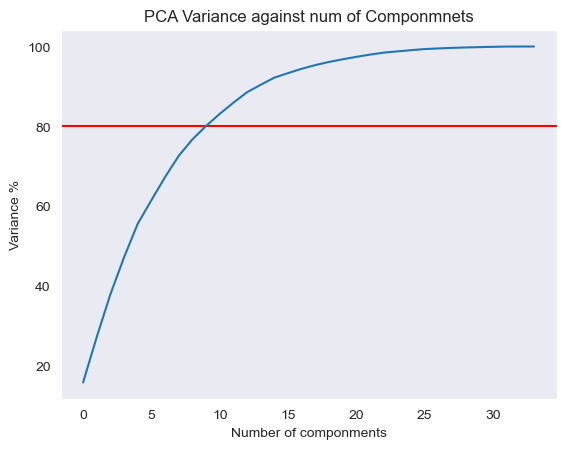

In [267]:
from sklearn.decomposition import PCA
pca = PCA()
df_train2= df_train.copy()
pca.fit(df_train2)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against num of Componmnets")
plt.ylabel("Variance %")
plt.xlabel("Number of componments")
l = plt.axhline(80, color="red")

plt.plot(var1)
plt.grid()

In [268]:
pca = PCA(n_components=7)
pca_train=pca.fit_transform(df_train2)
pca_train

array([[-1.11066013,  1.08312611,  0.32875313, ..., -0.28413022,
         0.37130931,  0.3021236 ],
       [-1.14907516, -0.04261892, -0.43222014, ..., -0.34807496,
         0.66749195,  0.48259381],
       [-0.85397898, -0.95978478,  0.53291692, ...,  0.52119914,
         0.28661167, -0.51089744],
       ...,
       [ 1.10101742, -0.83440584,  0.40104595, ...,  0.84429791,
         0.31220787, -0.53224231],
       [ 0.38860901,  1.51640682, -0.00677571, ..., -0.21464248,
         0.33551871,  0.26532863],
       [-1.40045701,  0.98695723,  0.46093301, ...,  0.85154539,
         0.35505838,  0.29303581]])

In [269]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.737079,0.434343,0.878117,0.980292,0.902830,0.930680,0.764032,0.913422,0.387762,0.769231,0.646015,0.538462,0.20,0.0,0.0,0.918446,0.421053,0.766810,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.327638,0.25,0.00,0.0,0.0,0.0,1.0,0.0,0.0
1,0.739394,0.747475,0.922059,0.990548,0.933131,0.906961,0.857423,0.697306,0.244651,0.384615,0.715338,0.923077,0.10,0.0,0.0,0.922649,0.543860,0.636624,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.374556,0.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0
2,0.747191,0.858586,0.866009,0.716925,0.886832,0.989230,0.716925,0.609856,0.244651,0.384615,0.556641,0.538462,0.05,0.0,1.0,0.825299,0.789474,0.240343,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.562022,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0
3,0.652594,0.252525,0.851438,0.000000,0.780785,0.530136,0.627134,0.490459,0.632412,0.615385,0.430677,0.615385,0.25,0.0,1.0,0.541107,0.438596,0.371960,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.309317,0.00,0.50,1.0,0.0,0.0,1.0,0.0,0.0
4,0.797797,0.646465,0.893697,0.847758,0.956094,0.782659,0.764032,0.781947,0.000000,0.307692,0.646015,0.615385,0.25,0.0,1.0,0.863225,0.596491,0.808298,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.296280,0.50,0.00,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,0.638018,0.666667,0.948048,0.671290,0.908444,0.671290,0.000000,0.672571,0.244651,0.461538,0.604531,0.846154,0.10,0.0,1.0,0.649478,0.192982,0.290415,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.414255,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0
6880,0.710824,0.080808,0.902569,0.835842,0.992597,0.994418,0.000000,0.808827,0.244651,0.384615,0.646015,0.538462,0.10,0.0,1.0,0.768709,0.350877,0.937053,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235139,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0
6881,0.354113,0.303030,0.654573,0.000000,0.512845,0.000000,0.000000,0.324508,0.387762,0.230769,0.215338,0.307692,0.30,0.0,1.0,0.195477,0.666667,0.280401,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.145638,0.00,0.25,1.0,0.0,0.0,0.0,1.0,0.0
6882,0.280229,0.080808,0.457063,0.578553,0.558695,0.578553,0.556757,0.523480,0.244651,0.230769,0.215338,0.230769,0.40,0.0,0.0,0.515174,0.280702,0.849785,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.169690,0.00,0.25,1.0,0.0,1.0,0.0,0.0,0.0


7 variaveis explicam ~80% da variancia

## Loading Scores for each PC

##  Correlação entre PC's e as variáveis originais

## Model Train

In [270]:
from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters = 3, max_iter =10000, random_state= 1)
kmeans.fit(pca_train)
pca_train_label = kmeans.labels_
pca_train_label = pd.DataFrame(pca_train_label)

In [294]:
df.reset_index(inplace=True)
pca_train_label.reset_index(inplace=True)
df_final=pd.concat([df,pca_train_label],axis=1)
df_final.set_index('CustomerID',inplace=True)
df_final.drop(['index'],axis=1,inplace=True)
df_final= df_final.rename(columns={0:'Cluster'})
df_final.drop(['Name'],axis=1,inplace=True)
df_final

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Gender,MntTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]",level_0,Cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,113947.0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,0,19.242890,42,823,1,0,0,0,0,1,0,0.023381,0.30103,0,0,0,0,1,0,0,0,2
19070,114297.0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,0,19.321940,49,732,1,0,0,0,1,0,0,0.026396,0.00000,0,0,0,0,1,0,0,1,1
29888,115476.0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,1,17.490921,63,455,0,0,0,1,1,0,0,0.038442,0.00000,0,0,0,0,0,1,0,2,1
12221,101172.0,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,1,12.145689,43,547,1,0,0,0,1,0,0,0.022204,0.00000,2,1,0,0,1,0,0,3,0
21107,123128.0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,1,18.204269,52,852,0,1,0,0,0,1,0,0.021367,0.60206,0,0,0,0,1,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30686,98968.0,66.0,3.958612,2.416641,3.779308,2.416641,0.000000,1.612784,0.301030,6,0.845098,11,2,0.0,1,14.183984,29,490,0,0,0,1,0,0,0,0.028947,0.00000,0,0,1,0,0,0,0,6879,1
17210,109977.0,8.0,3.768712,3.009026,4.129400,3.579898,0.000000,1.939519,0.301030,5,0.903090,7,2,0.0,1,16.426555,38,942,1,0,0,0,0,0,0,0.017438,0.00000,0,0,0,1,0,0,0,6880,1
29186,56039.0,30.0,2.733197,0.000000,2.133539,0.000000,0.000000,0.778151,0.477121,3,0.301030,4,6,0.0,1,5.644887,56,483,0,0,0,1,1,0,0,0.011687,0.00000,1,1,0,0,0,1,0,6881,0


In [272]:
#kmeans2= KMeans(n_clusters = 7, max_iter = 10000, random_state = 1)
#kmeans2.fit(df_train)
#df_train_label = kmeans2.labels_

In [296]:
df_final.groupby('Cluster').mean().transpose()

Cluster,0,1,2
Income,56490.778938,100235.039823,74425.864063
Recency,49.075532,49.989026,48.347490
MntMeat&Fish,2.548090,3.597691,2.990227
MntEntries,1.376941,2.777828,2.044826
MntVegan&Vegetarian,2.455450,3.568822,2.962137
MntDrinks,1.372972,2.761218,2.070432
MntDesserts,1.370252,2.778656,2.042457
MntAdditionalRequests,1.075430,1.671046,1.374475
NumOfferPurchases,0.507622,0.415561,0.486829
NumAppPurchases,4.960713,7.397804,6.116582


In [273]:
#dfTF= pd.DataFrame()
#dfTF['Compare'] = pca_train_label== df_train_label
#pd.DataFrame(dfTF.groupby('Compare'))
#dfTF.groupby(['Compare']).size().reset_index(name='counts')

### 3.2.2. Misclassifications

### 3.2.3. Incoherencies

> 3.2.3.1 Clients that spent money but never had a registered Purchase

### 3.2.5. Reclassification

### 3.2.6. Power Transform

## 3.3. Data Reduction

### 3.3.1. Multicollinearity - Check correlation

### 3.3.2. Unary Variables

### 3.3.3. Variables with a high percentage of missing values

## 3.2. Back to Data Transformation

### 3.2.7. Apply ordinal encoding and create Dummy variables

### 3.2.8. Scaling

## 4. Models

### 4.1. K-Means

In [274]:
# variavel modelo visao monetary: 
        #  Mnt_pday_card, has_Kids, Income, age_bins, 'Graduation', 'HighSchool', 'Master', 'PhD', 'Gender'

In [275]:
df_value = df[["Mnt_pday_card", "has_Kids", "Income", "Age", 'Graduation', 'HighSchool', 'Master', 'PhD', 'Gender', "Recency" ]].copy()

In [276]:
ks = range(1,11)
inertias = []


for k in ks:
    model = KMeans(n_clusters = k).fit(df_value)
    inertias.append(model.inertia_)

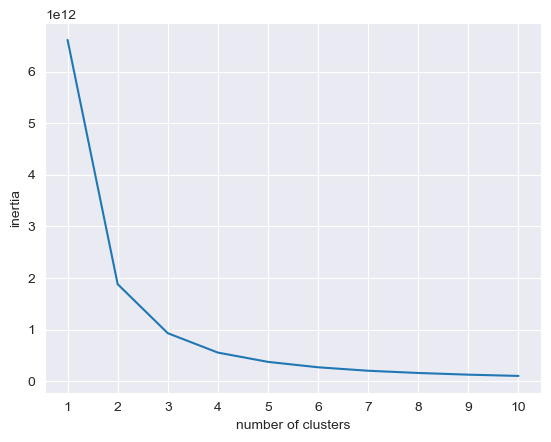

In [277]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for the x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for the y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks on the x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

In [278]:
df_value_k2 = df_final.copy()
model_k2 = sk.cluster.KMeans(n_clusters = 2, random_state = 1).fit(df_value_k2)

In [279]:
df_value_k2["label"] = model_k2.labels_

In [280]:
df_value_k2["label"].value_counts()

0    3497
1    3387
Name: label, dtype: int64

In [281]:
df_value_k2.groupby(["label"]).mean().transpose()

label,0,1
Income,101949.380898,49496.085740
Recency,49.738409,48.649970
MntMeat&Fish,3.629548,2.395995
MntEntries,2.507258,1.537772
MntVegan&Vegetarian,3.482623,2.437664
MntDrinks,2.509491,1.533991
MntDesserts,2.505375,1.533630
MntAdditionalRequests,1.613339,1.092484
NumOfferPurchases,0.444146,0.497949
NumAppPurchases,7.477838,4.668733


In [282]:
df_value_k3 = df_final.copy()
model_k3 = sk.cluster.KMeans(n_clusters = 3, random_state = 2).fit(df_value_k3)

In [283]:
df_value_k3["label"] = model_k3.labels_

In [284]:
df_value_k3["label"].value_counts()

2    2477
0    2205
1    2202
Name: label, dtype: int64

In [285]:
df_value_k3.groupby(["label"]).describe()

Income                                                            \
        count           mean           std      min       25%       50%   
label                                                                     
0      2205.0   40075.228753  12649.629907   2493.8   32073.0   42140.0   
1      2202.0  111898.323342  11911.385880  94190.0  102003.0  110463.5   
2      2477.0   76461.138474  10358.067573  58319.0   67539.0   76563.0   

                          Recency                                         \
            75%       max   count       mean        std  min   25%   50%   
label                                                                      
0       50335.0   58261.0  2205.0  48.029130  28.685881  0.0  24.0  47.0   
1      120247.0  153703.0  2202.0  50.154320  29.170472  0.0  25.0  50.0   
2       85474.0   94184.0  2477.0  49.401947  28.702784  0.0  25.0  49.0   

                  MntMeat&Fish                                          \
        75%   max        count      mean       std       min       25%   
label                                                                    
0      72.0  99.0       2205.0  2.105735  0.662709  0.000000  1.707570   
1      75.0  99.0       2202.0  3.728965  0.264701  2.232996  3.580183   
2      74.0  99.0       2477.0  3.210915  0.523606  1.322219  2.869818   

                                    MntEntries                           \
            50%       75%       max      count      mean       std  min   
label                                                                     
0      2.149219  2.545307  3.691170     2205.0  1.538557  0.898818  0.0   
1      3.774955  3.927422  4.175541     2202.0  2.782238  0.777867  0.0   
2      3.320354  3.608633  4.135800     2477.0  1.799478  1.088178  0.0   

                                              MntVegan&Vegetarian            \
            25%       50%       75%       max               count      mean   
label                                                                         
0      1.322219  1.785330  2.149219  3.480151              2205.0  2.298451   
1      2.636488  2.935003  3.235781  3.599992              2202.0  3.690428   
2      1.322219  2.082785  2.624282  3.599992              2477.0  2.923171   

                                                                  MntDrinks  \
            std       min       25%       50%       75%       max     count   
label                                                                         
0      0.502238  0.000000  2.025306  2.292256  2.575188  3.839855    2205.0   
1      0.308971  2.382017  3.494294  3.745543  3.934864  4.160198    2202.0   
2      0.505445  1.204120  2.592177  2.982723  3.296884  4.079760    2477.0   

                                                                        \
           mean       std  min       25%       50%       75%       max   
label                                                                    
0      1.513672  0.914174  0.0  1.322219  1.785330  2.149219  3.563600   
1      2.770264  0.812614  0.0  2.627870  2.944976  3.250664  3.599992   
2      1.830259  1.076673  0.0  1.322219  2.082785  2.658011  3.599992   

      MntDesserts                                                         \
            count      mean       std  min       25%       50%       75%   
label                                                                      
0          2205.0  1.516617  0.911961  0.0  1.322219  1.785330  2.149219   
1          2202.0  2.764403  0.825500  0.0  2.624282  2.935003  3.260310   
2          2477.0  1.826543  1.065588  0.0  1.322219  2.082785  2.603144   

                MntAdditionalRequests                                     \
            max                 count      mean       std  min       25%   
label                                                                      
0      3.497068                2205.0  1.014310  0.466914  0.0  0.698970   
1      3.599992                2202.0  1.666423

Measuring distances between clusters

In [286]:
from sklearn.metrics.pairwise import euclidean_distances

dists_k2 = euclidean_distances(model_k2.cluster_centers_)
dists_k2

array([[    0.        , 52453.29631253],
       [52453.29631253,     0.        ]])

In [287]:
dists_k3 = euclidean_distances(model_k3.cluster_centers_)
dists_k3

array([[    0.        , 71831.14203586, 36393.06531194],
       [71831.14203586,     0.        , 35438.07839996],
       [36393.06531194, 35438.07839996,     0.        ]])

### Visualization

In [288]:
cluster0 = df_value_k2[df_value_k2.label == 0]
cluster1 = df_value_k2[df_value_k2.label == 1]


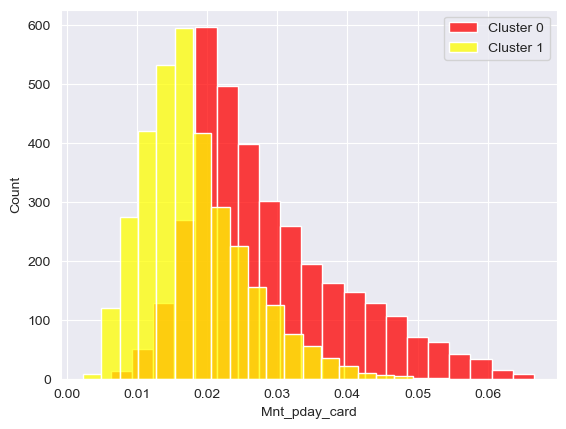

In [289]:
sns.histplot(cluster0['Mnt_pday_card'],color='red',label='Cluster 0', bins = 20)
sns.histplot(cluster1['Mnt_pday_card'],color='yellow',label='Cluster 1', bins = 20)
plt.legend()

In [290]:
cluster0 = df_value_k3[df_value_k3.label == 0]
cluster1 = df_value_k3[df_value_k3.label == 1]
cluster2 = df_value_k3[df_value_k3.label == 2]

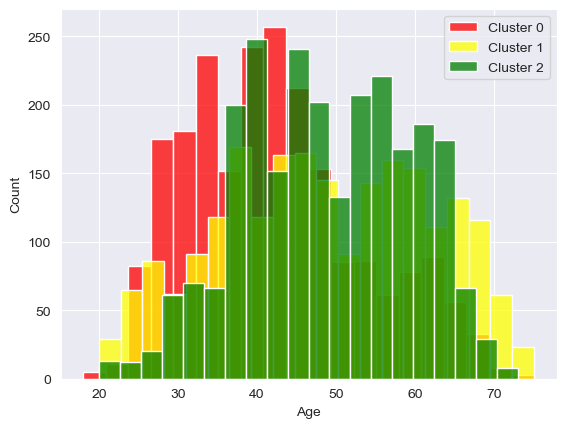

In [291]:
sns.histplot(cluster0['Age'],color='red',label='Cluster 0', bins = 20)
sns.histplot(cluster1['Age'],color='yellow',label='Cluster 1', bins = 20)
sns.histplot(cluster2['Age'],color='green',label='Cluster 2', bins = 20)
plt.legend()

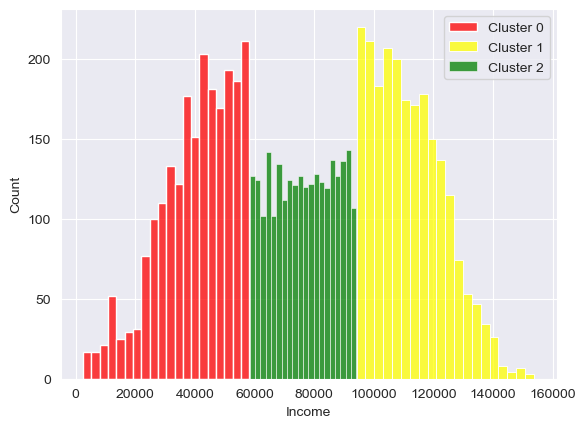

In [292]:
sns.histplot(cluster0['Income'],color='red',label='Cluster 0', bins = 20)
sns.histplot(cluster1['Income'],color='yellow',label='Cluster 1', bins = 20)
sns.histplot(cluster2['Income'],color='green',label='Cluster 2', bins = 20)
plt.legend()

In [293]:
# variavel modelo visao customer behaviour: NumOfferPurchases', 'NumAppPurchases',
       # 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth',
       # 'Complain', 'Gender', 'Income', 'Age', 'Graduation', 'HighSchool', 'Master', 'PhD', 'Married', 'Single',
       # 'Widow'